/var/folders/k2/jhfpx2pj2jv7d5yy75m0ktp80000gn/T/ipykernel_54237/548754584.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df.loc[:, 'Adj Close_GLD'] - hedge_ratio[0]*df.loc[:, 'Adj Close_GDX']
/var/folders/k2/jhfpx2pj2jv7d5yy75m0ktp80000gn/T/ipykernel_54237/548754584.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal


np.float64(1.494313761833427)

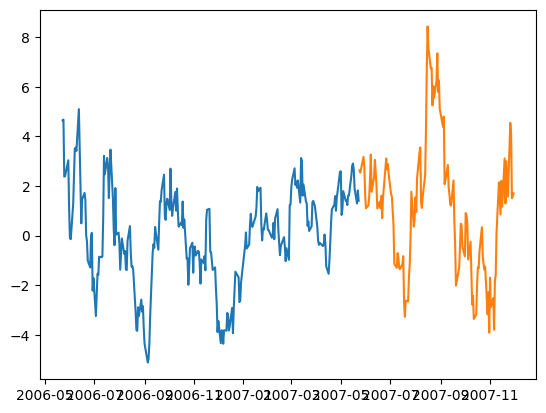

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
df1 = pd.read_excel('GLD.xls')
df2 = pd.read_excel('GDX.xls')
df = pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))
df
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

train = np.arange(0, 252)
test = np.arange(train.shape[0], df.shape[0])
model = sm.OLS(df.loc[:, 'Adj Close_GLD'].iloc[train], df.loc[:, 'Adj Close_GDX'].iloc[train])
results = model.fit()
hedge_ratio = results.params
spread = df.loc[:, 'Adj Close_GLD'] - hedge_ratio[0]*df.loc[:, 'Adj Close_GDX']
plt.plot(spread.iloc[train])
plt.plot(spread.iloc[test])
spread_mean = np.mean(spread.iloc[train])
spread_mean
spread_std = np.std(spread.iloc[train])
spread_std
df['zscore'] = (spread - spread_mean)/spread_std
df['positions_GLD_Long'] = 0
df['positions_GDX_Long'] = 0
df['positions_GLD_Short'] = 0
df['positions_GDX_Short'] = 0
df.loc[df.zscore>=2, ('positions_GLD_Short', 'positions_GDX_Short')]=[-1, 1] # Short spread
df.loc[df.zscore<=-2, ('positions_GLD_Long', 'positions_GDX_Long')]=[1, -1] # Buy spread
df.loc[df.zscore<=1, ('positions_GLD_Short', 'positions_GDX_Short')]=0 # Exit short spread
df.loc[df.zscore>=-1, ('positions_GLD_Long', 'positions_GDX_Long')]=0 # Exit long spread
df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal
positions_Long=df.loc[:, ('positions_GLD_Long', 'positions_GDX_Long')]
positions_Short=df.loc[:, ('positions_GLD_Short', 'positions_GDX_Short')]
positions=np.array(positions_Long)+np.array(positions_Short)
positions=pd.DataFrame(positions)
dailyret=df.loc[:, ('Adj Close_GLD', 'Adj Close_GDX')].pct_change()
pnl=(np.array(positions.shift())*np.array(dailyret)).sum(axis=1)

sharpe_train = np.sqrt(252)*np.mean(pnl[train[1:]])/np.std(pnl[train[1:]])
sharpe_train
sharpe_test = np.sqrt(252)*np.mean(pnl[test])/np.std(pnl[test])
sharpe_test

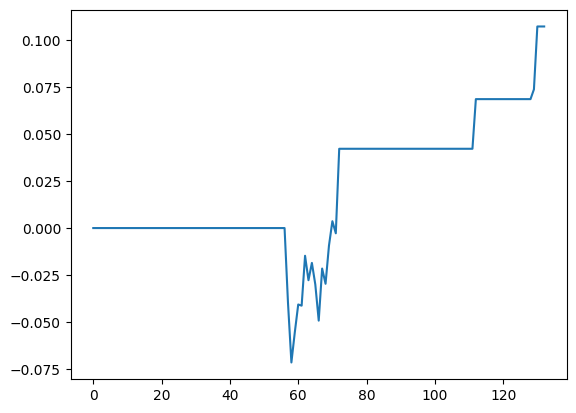

In [11]:
plt.plot(np.cumsum(pnl[test]))
positions.to_pickle('example3_6_positions')